In [1]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
gdData = pd.read_csv('RealGDPQuarterly.csv')
RainData = pd.read_csv('QuarterlyRain.csv')

In [3]:
gdpData = gdData[['tyear','Period','GDPat2010ConstantBasicPrices','CrudePetroleumAndNaturalGas']]
gdpData = gdpData.rename(columns={
    'tyear': 'Year',
    'GDPat2010ConstantBasicPrices': 'GDP',
    'CrudePetroleumAndNaturalGas': 'CrudeOil'})
gdpData.head()

,Year,Period,GDP,CrudeOil
0,2010,Q1,12583.48,1537.63
1,2010,Q2,12934.53,1483.89
2,2010,Q3,14304.44,1650.03
3,2010,Q4,14789.82,1700.12
4,2011,Q1,13450.72,1756.68


In [4]:
RainData = RainData.dropna()
RainData.head()

,Year,Period,RainDta
0,2010,Q1,46.50
1,2010,Q2,162.77
2,2010,Q3,198.63
3,2010,Q4,25.17
4,2011,Q1,23.13


In [5]:
# Merge the two datasets on Month and Year
gdpData = pd.merge(gdpData, RainData,    on=['Period', 'Year'])

In [46]:
gdpData = gdpData.dropna()

# Create a dictionary to map the Period to a month
period_to_month = {
    "Q1": "01-01",
    "Q2": "04-01",
    "Q3": "07-01",
    "Q4": "10-01"
}

# Create the date column by combining Year and Period
gdpData['date'] = gdpData.apply(lambda row: f"{row['Year']}-{period_to_month[row['Period']]}", axis=1)

# Convert the date column to datetime format
gdpData['date'] = pd.to_datetime(gdpData['date'])

gdpData.head(10)

,Year,Period,GDP,CrudeOil,RainDta,Year_Period,z_score,date
0,2010,Q1,12583.48,1537.63,46.50,2010-Q1,0.160048,2010-01-01
1,2010,Q2,12934.53,1483.89,162.77,2010-Q2,-0.059454,2010-04-01
2,2010,Q3,14304.44,1650.03,198.63,2010-Q3,0.619146,2010-07-01
3,2010,Q4,14789.82,1700.12,25.17,2010-Q4,0.823738,2010-10-01
4,2011,Q1,13450.72,1756.68,23.13,2011-Q1,1.054758,2011-01-01
5,2011,Q2,13757.73,1760.57,210.30,2011-Q2,1.070647,2011-04-01
6,2011,Q3,14819.62,1780.20,177.80,2011-Q3,1.150825,2011-07-01
7,2011,Q4,15482.97,1676.19,97.10,2011-Q4,0.725996,2011-10-01
8,2012,Q1,13915.51,1600.30,36.80,2012-Q1,0.416023,2012-01-01
9,2012,Q2,14323.05,1570.22,196.93,2012-Q2,0.293162,2012-04-01


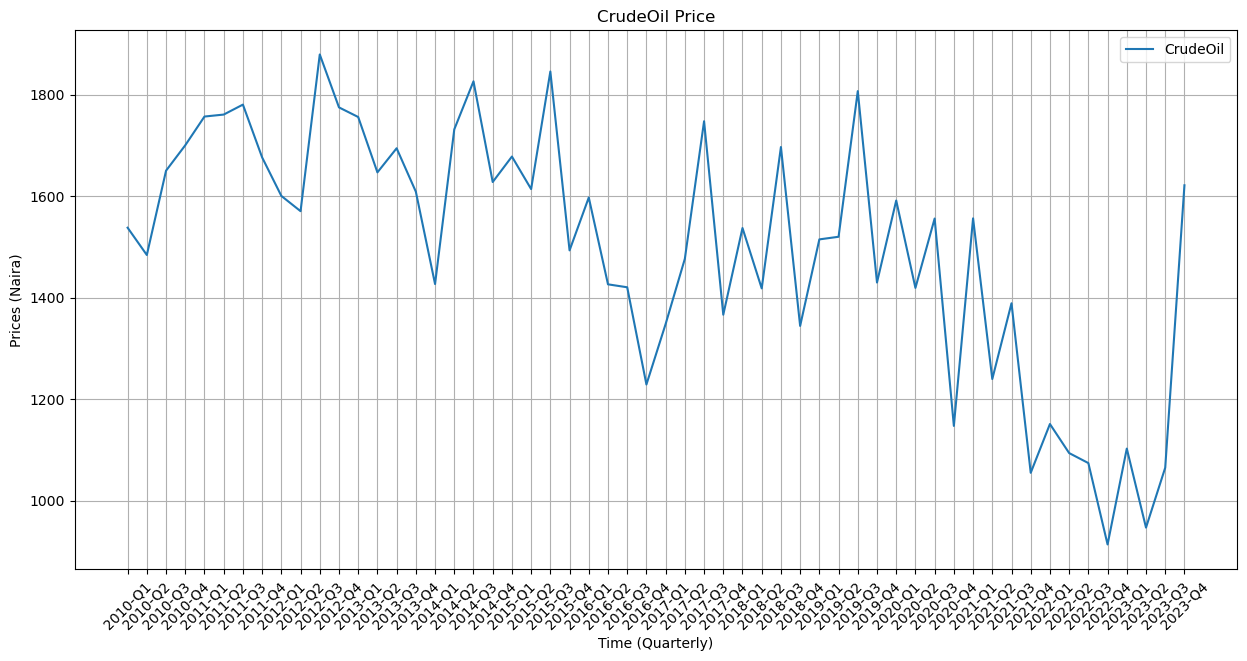

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7


# Define the data

# Create DataFrame
df = pd.DataFrame(gdpData)

# Plot transformed data
plt.plot(df['Year_Period'], df['CrudeOil'].dropna(), label='CrudeOil')
plt.title('CrudeOil Price')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Prices (Naira)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


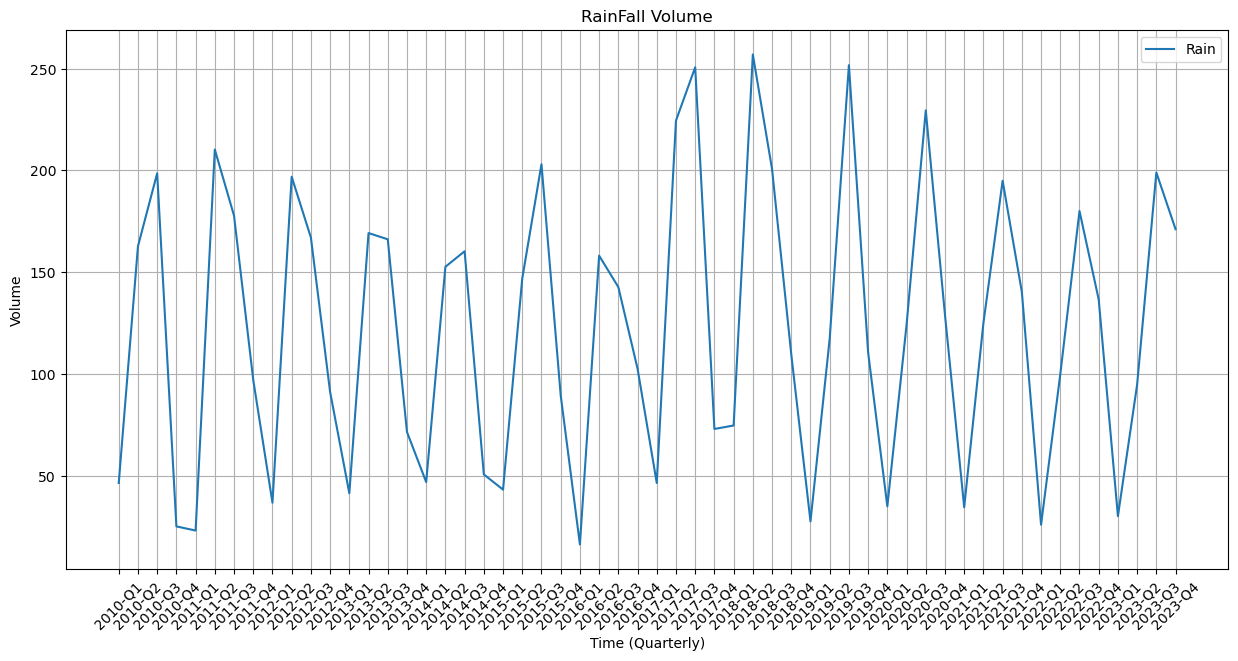

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7


# Define the data

# Create DataFrame
df = pd.DataFrame(gdpData)

plt.plot(df['Year_Period'], df['RainDta'].dropna(), label='Rain')
plt.title('RainFall Volume')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [49]:
dat2012 = df[(df['Year'] >= 2012) & (df['Year'] <= 2012)] 
dat2012.head()

,Year,Period,GDP,CrudeOil,RainDta,Year_Period,z_score,date
8,2012,Q1,13915.51,1600.30,36.80,2012-Q1,0.416023,2012-01-01
9,2012,Q2,14323.05,1570.22,196.93,2012-Q2,0.293162,2012-04-01
10,2012,Q3,15645.43,1879.02,167.07,2012-Q3,1.554456,2012-07-01
11,2012,Q4,16045.90,1774.72,91.20,2012-Q4,1.128442,2012-10-01


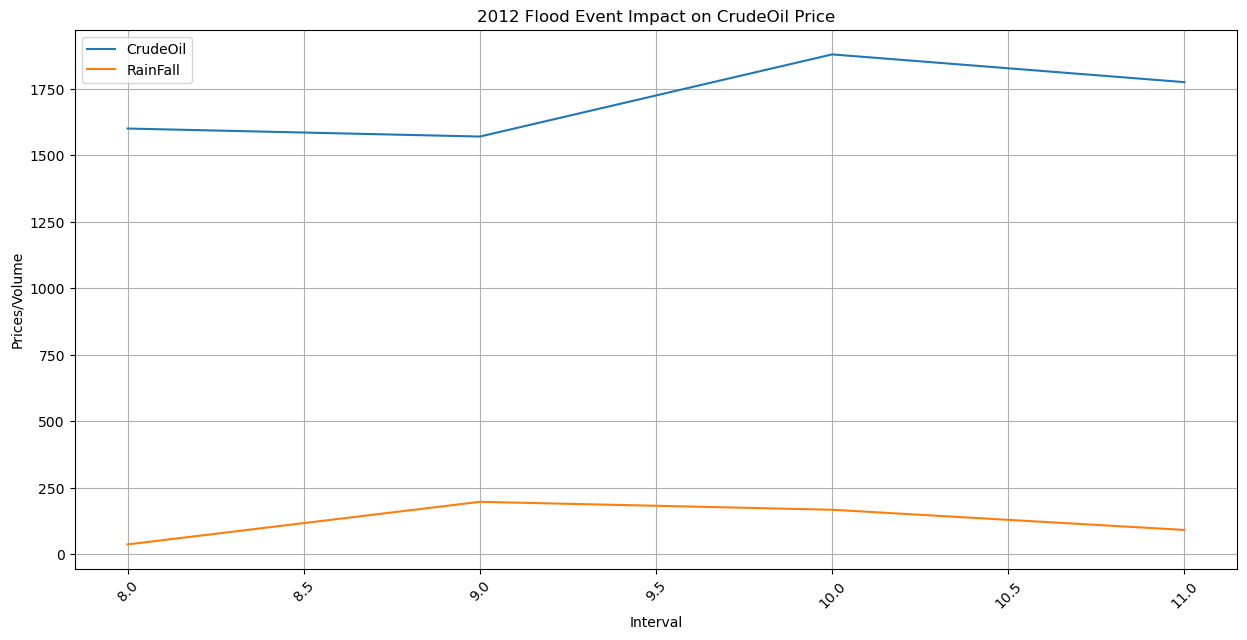

In [50]:
# Plot transformed data
plt.plot(dat2012['CrudeOil'].dropna(), label='CrudeOil')
plt.plot(dat2012['RainDta'].dropna(), label='RainFall')
plt.title('2012 Flood Event Impact on CrudeOil Price')
plt.xlabel('Interval')
plt.ylabel('Prices/Volume')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

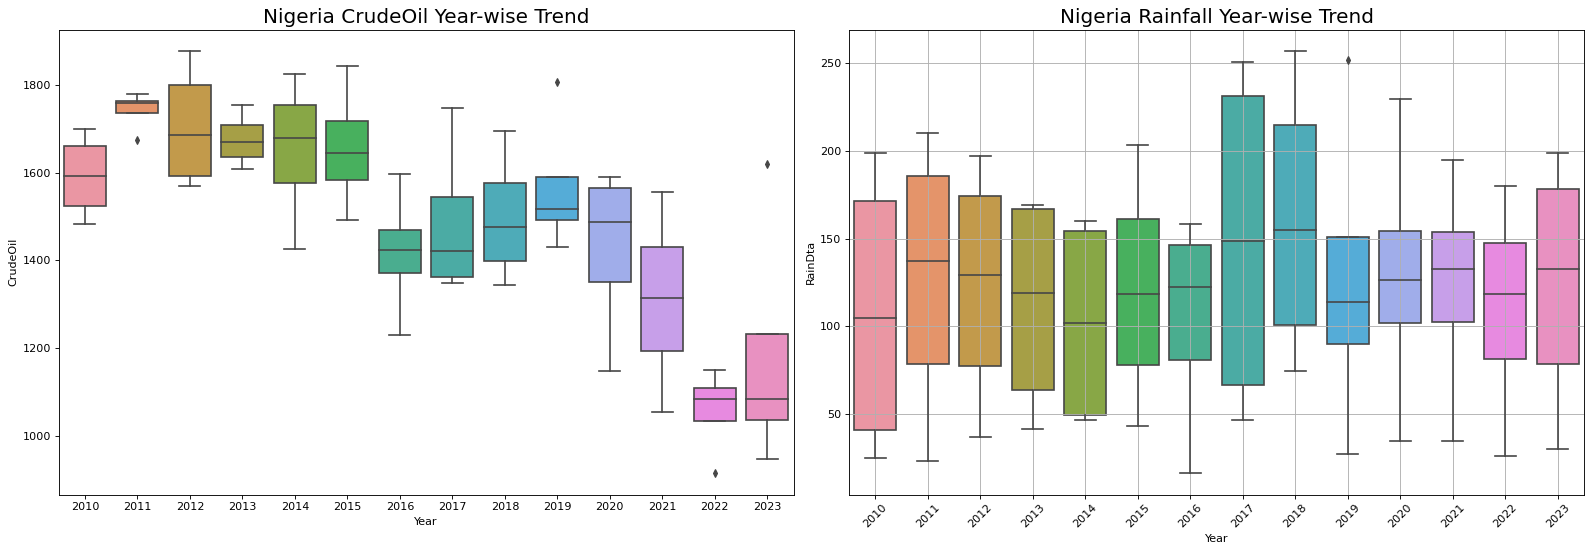

In [51]:
df['GDP'] = pd.to_numeric(df['CrudeOil'])

df_sorted = df.sort_values(by=['Year', 'Period', 'CrudeOil'])
df_sorted['Year_Month'] = df_sorted['Year'].astype(str) + '-' + df_sorted['Period'].astype(str).str.zfill(2)
# Prepare data
years = df_sorted['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi=80)
sns.boxplot(x='Year', y='CrudeOil', data=df_sorted, ax=axes[0])
sns.boxplot(x='Year', y='RainDta', data=df_sorted, ax=axes[1])
# Set Title
axes[0].set_title('Nigeria CrudeOil Year-wise Trend', fontsize=18); 
axes[1].set_title('Nigeria Rainfall Year-wise Trend', fontsize=18)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# method to plot correlation between two variable while computing their Correlatio coefficient along

def corp(x, y_list, xlabel, ylabel_list):
    for y, ylabel in zip(y_list, ylabel_list):
        ccoefficient = gdpData[x].corr(gdpData[y])
        print(f'Correlation coefficient between {xlabel} and {ylabel}:', ccoefficient.round(2))
        

# passing plot parameters and plotting chart
x = 'CrudeOil'
y = ['RainDta']
xlabel = 'CrudeOil'
ylabel_list = ['RainDta']
corp(x,y,x,y)




Correlation coefficient between CrudeOil and RainDta: 0.12


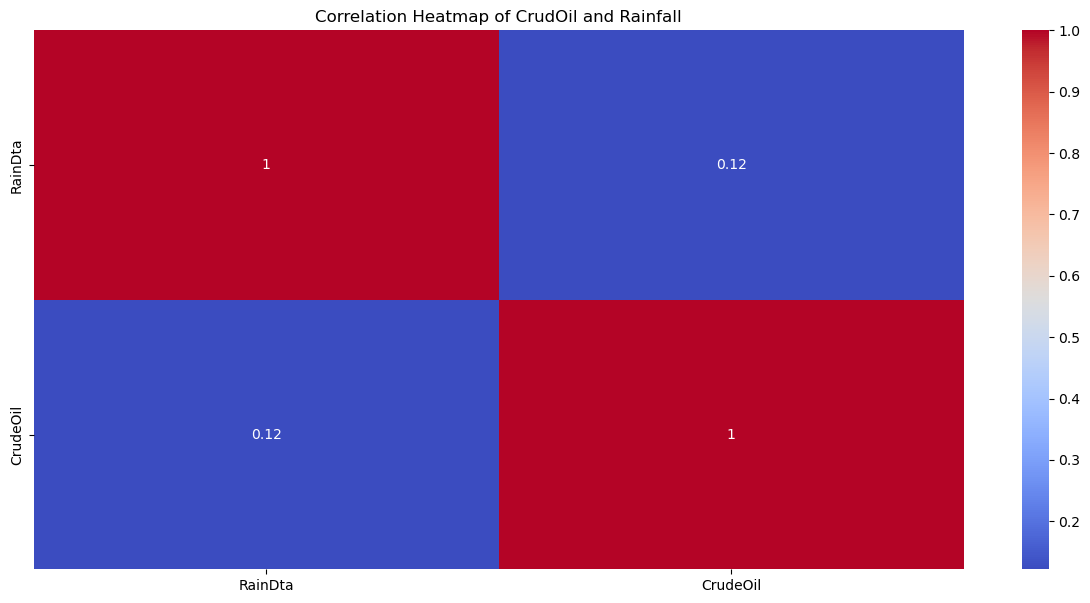

In [53]:
Independent_vars = ['RainDta','CrudeOil']
correlations = gdpData[Independent_vars].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of CrudOil and Rainfall')
plt.show()

In [54]:
# Calculate Z-scores
gdpData['z_score'] = (gdpData['CrudeOil'] - gdpData['CrudeOil'].mean()) / gdpData['CrudeOil'].std()

# Identify outliers
outliers = gdpData[np.abs(gdpData['z_score']) > 3]


# Remove the outliers
Remove_Outlier = gdpData[(np.abs(gdpData['z_score']) <= 3)]

# Drop the Z-score columns as they are no longer needed
Dff_DropColumn = Remove_Outlier.drop(columns=['z_score'])


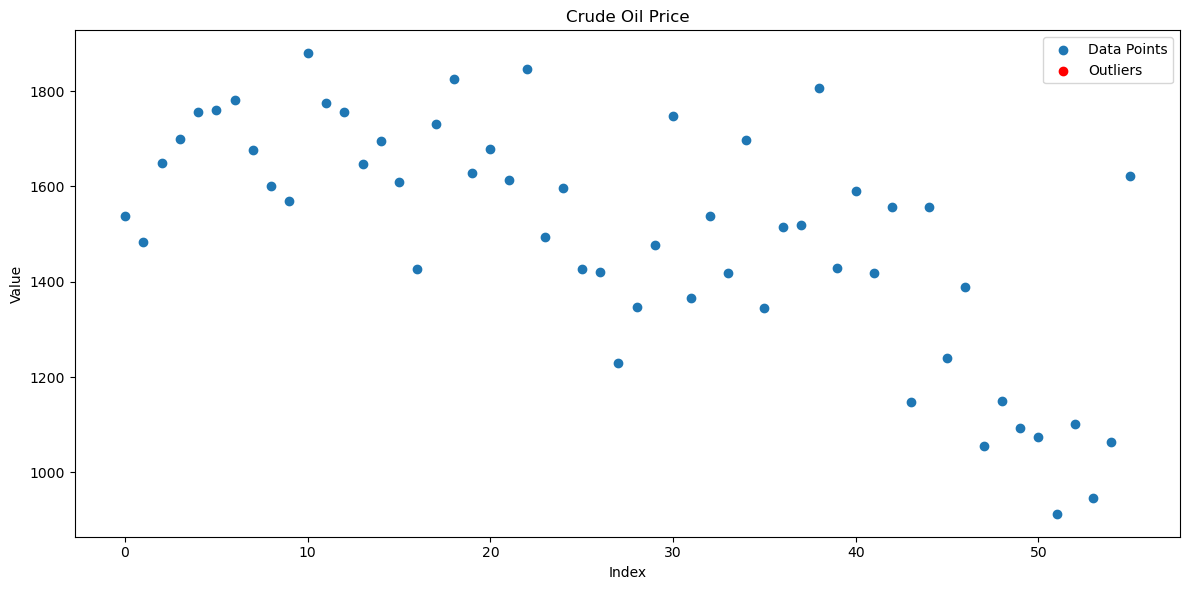

In [55]:
# Create a single plot
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for data points
ax.scatter(gdpData.index, gdpData['CrudeOil'], label='Data Points')
# Scatter plot for outliers
ax.scatter(outliers.index, outliers['CrudeOil'], color='red', label='Outliers')

# Setting labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()
ax.set_title('Crude Oil Price')

# Show the plot
plt.tight_layout()
plt.show()

In [56]:
# Convert to DataFrames
df_crude_oil = pd.DataFrame(Dff_DropColumn['CrudeOil'])
df_rain = pd.DataFrame(RainData['RainDta'])

# Merge the DataFrames based on their indices
df_merged = pd.concat([df_crude_oil, df_rain], axis=1)

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests
# Perform Granger Causality Test
max_lag = 4  # You can adjust the max lag based on your requirements
test_result = grangercausalitytests(df_merged, max_lag, verbose=True)

# Display the test results
print(test_result)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9856  , df_denom=52, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9851  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9851  , df=1
parameter F test:         F=0.0003  , p=0.9856  , df_denom=52, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4722  , p=0.0389  , df_denom=49, df_num=2
ssr based chi2 test:   chi2=7.6531  , p=0.0218  , df=2
likelihood ratio test: chi2=7.1571  , p=0.0279  , df=2
parameter F test:         F=3.4722  , p=0.0389  , df_denom=49, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0372  , p=0.1218  , df_denom=46, df_num=3
ssr based chi2 test:   chi2=7.0417  , p=0.0706  , df=3
likelihood ratio test: chi2=6.6116  , p=0.0854  , df=3
parameter F test:         F=2.0372  , p=0.1218  , df_denom=46, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9132  , p=0.4649  , df_d

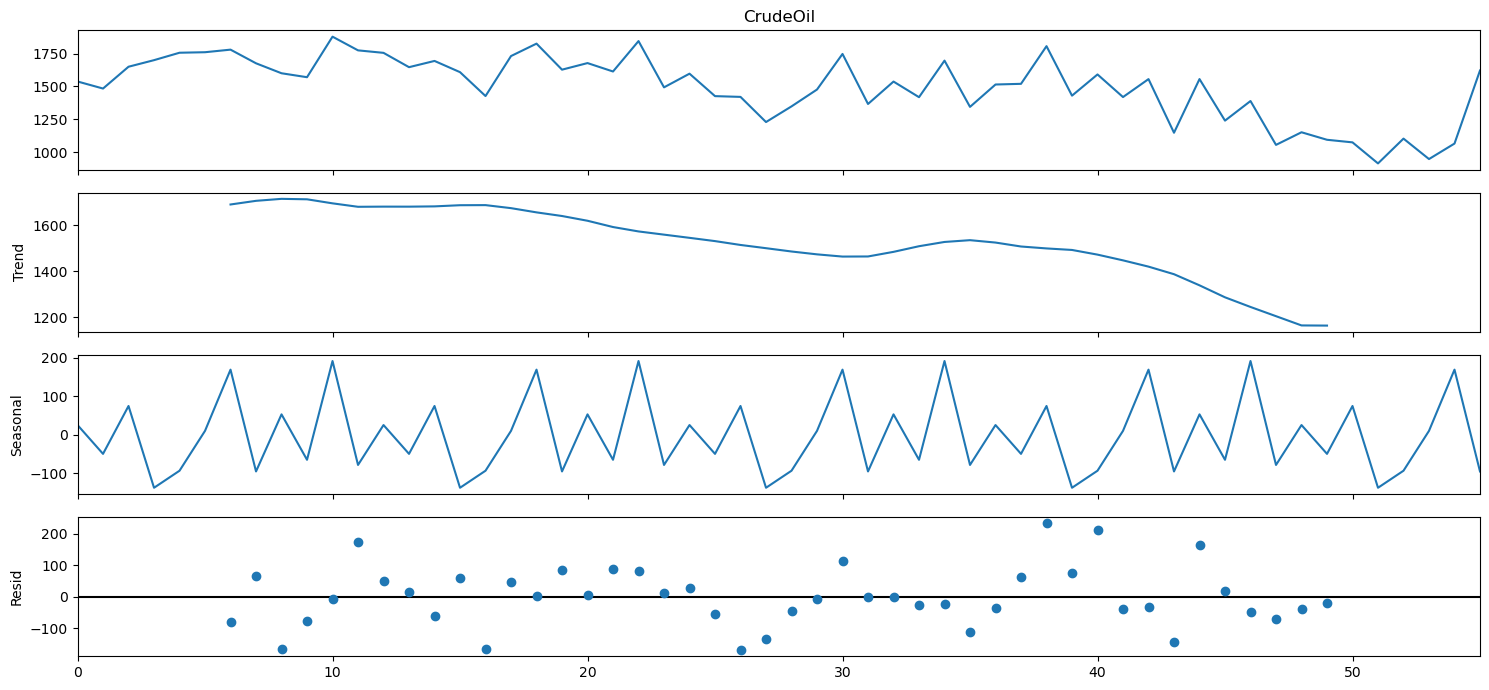

In [58]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
result = sm.tsa.seasonal_decompose(Dff_DropColumn['CrudeOil'].dropna(), model='additive', period=12)
# Plot the decomposed components
fig = result.plot()
plt.show()

In [59]:
def adfuller_test(prices, title=''):
    result=adfuller(prices)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    summary = {
        'Series': title,
        'ADF Statistic': adf_statistic,
        'p-value': p_value,
        'Critical Value (1%)': critical_values['1%'],
        'Critical Value (5%)': critical_values['5%'],
        'Critical Value (10%)': critical_values['10%']
    }
    return summary

#df_Main = df_sorted.drop(columns=['percentChange', 'date', 'change', 'Months', 'Years', 'price'])
# Run ADF test on each differenced series
results = []
results.append(adfuller_test(Dff_DropColumn['CrudeOil'], 'CrudeOil'))

# Convert results to DataFrame
adf_results_df = pd.DataFrame(results)

adf_results_df

,Series,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,CrudeOil,-1.882549,0.340315,-3.565624,-2.920142,-2.598015


In [60]:
Dff_DropColumn['CrudeOil_First_Diff'] = Dff_DropColumn['CrudeOil'].diff()
Dff_DropColumn['CrudeOil_Second_Diff'] = Dff_DropColumn['CrudeOil_First_Diff'].diff()
results = []
results.append(adfuller_test(Dff_DropColumn['CrudeOil_First_Diff'].dropna(), 'CrudeOil'))

# Convert results to DataFrame
adf_results_df = pd.DataFrame(results)

adf_results_df

,Series,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,CrudeOil,-5.978699,1.860719e-07,-3.562879,-2.918973,-2.597393


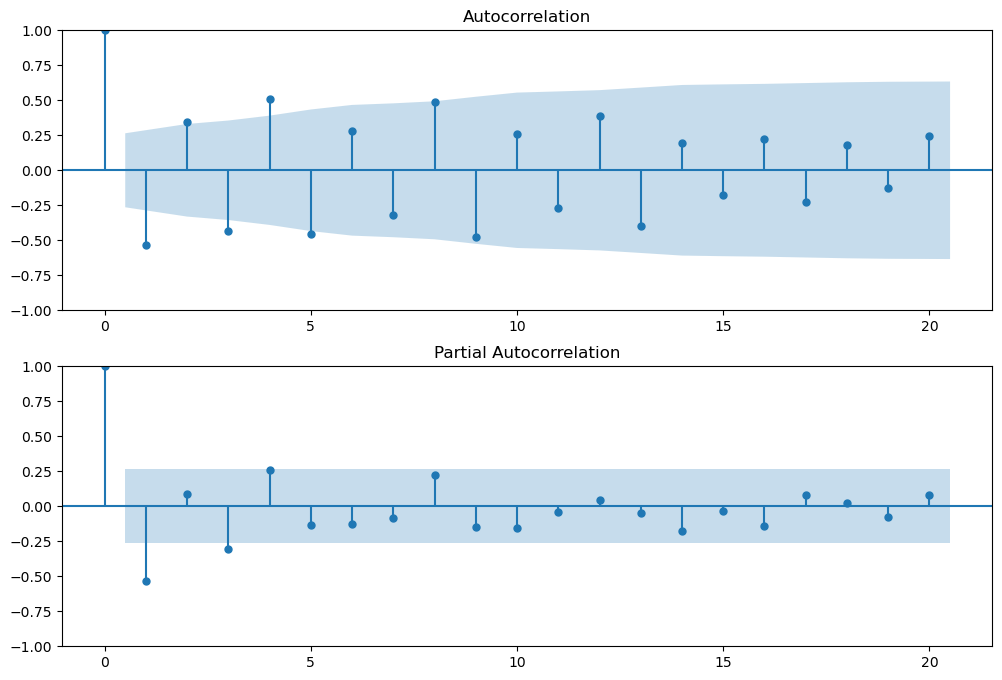

In [61]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Dff_DropColumn['CrudeOil_First_Diff'].dropna(),lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Dff_DropColumn['CrudeOil_First_Diff'].dropna(),lags=20,ax=ax2)

In [65]:
Dff_DropColumn.head(10)

,Year,Period,GDP,CrudeOil,RainDta,Year_Period,date,CrudeOil_First_Diff,CrudeOil_Second_Diff
0,2010,Q1,1537.63,1537.63,46.50,2010-Q1,2010-01-01,NaN,NaN
1,2010,Q2,1483.89,1483.89,162.77,2010-Q2,2010-04-01,-53.74,NaN
2,2010,Q3,1650.03,1650.03,198.63,2010-Q3,2010-07-01,166.14,219.88
3,2010,Q4,1700.12,1700.12,25.17,2010-Q4,2010-10-01,50.09,-116.05
4,2011,Q1,1756.68,1756.68,23.13,2011-Q1,2011-01-01,56.56,6.47
5,2011,Q2,1760.57,1760.57,210.30,2011-Q2,2011-04-01,3.89,-52.67
6,2011,Q3,1780.20,1780.20,177.80,2011-Q3,2011-07-01,19.63,15.74
7,2011,Q4,1676.19,1676.19,97.10,2011-Q4,2011-10-01,-104.01,-123.64
8,2012,Q1,1600.30,1600.30,36.80,2012-Q1,2012-01-01,-75.89,28.12
9,2012,Q2,1570.22,1570.22,196.93,2012-Q2,2012-04-01,-30.08,45.81


In [151]:
# Split data into train and test sets
import itertools
import warnings
from pmdarima import auto_arima
CrudeData = Dff_DropColumn[['date', 'CrudeOil']].dropna()  # Drop any rows with NaN values
CrudeData.set_index('date', inplace=True)
size = int(len(CrudeData) * 0.70)
train = CrudeData.iloc[:size]
test = CrudeData.iloc[size:]


# Fit the model
model = sm.tsa.statespace.SARIMAX(train, 
                                  order=(3,1,1), 
                                  seasonal_order=(1,1,1,4))
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.get_prediction(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred_mean = predictions.predicted_mean
pred_conf = predictions.conf_int()

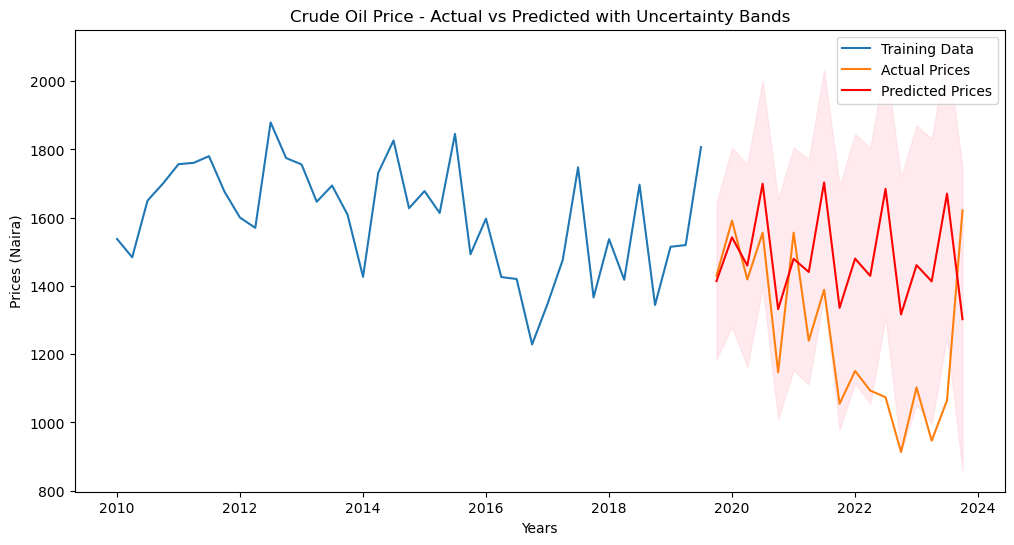

In [152]:
# Plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(test.index, pred_mean, label='Predicted Prices', color='red')
plt.fill_between(test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.xlabel('Years')
plt.ylabel('Prices (Naira)')
plt.title('Crude Oil Price - Actual vs Predicted with Uncertainty Bands')
plt.show()

In [157]:
test

,CrudeOil
date,
2019-10-01,1429.67
2020-01-01,1591.25
2020-04-01,1419.04
2020-07-01,1555.77
2020-10-01,1147.14
2021-01-01,1556.07
2021-04-01,1239.46
2021-07-01,1388.80
2021-10-01,1054.72


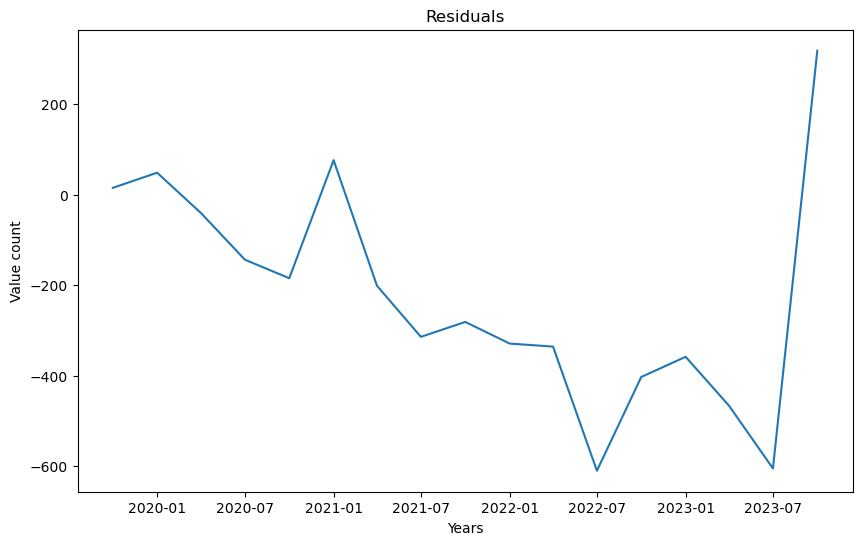

In [159]:
# Plot residuals
residuals = test['CrudeOil'] - pred_mean
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Years')
plt.ylabel('Value count')
plt.show()

In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate errors
mae = mean_absolute_error(test['CrudeOil'], pred_mean)
mape = np.mean(np.abs((test['CrudeOil'] - pred_mean) / test['CrudeOil'])) * 100
rmse = np.sqrt(mean_squared_error(test['CrudeOil'], pred_mean))

# Print results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 278.4793976303196
Mean Absolute Percentage Error (MAPE): 24.78760069133925
Root Mean Squared Error (RMSE): 330.2370259076579


      lb_stat  lb_pvalue
10  13.076691   0.219415


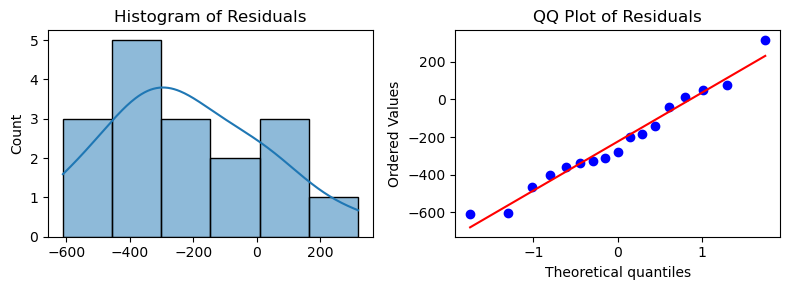

In [190]:

# Subtract pred_mean from test
residuals = test['CrudeOil'] - pred_mean

# Convert the result back to a pandas Series
residuals = pd.Series(residuals, index=test.index)
ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

print(ljung_box_test)

# Histogram and QQ plot for each residual
plt.figure(figsize=(8, 3))
    
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
    
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
    
plt.tight_layout()
plt.show()

In [203]:
RainData = RainData.dropna()
exog_train = RainData['RainDta'].iloc[:size]
exog_train_lag2 = RainData['RainDta'].shift(2)
exog_train_lag2_train = exog_train_lag2.iloc[:size]
exog_train_lag2_train = exog_train_lag2_train.dropna()
exog_test = RainData['RainDta'].iloc[size:]
exog_test_Lag2 = exog_train_lag2.iloc[size:]
exog_test_Lag2 = exog_test_Lag2.dropna()

# Align the endog variable with the exog variabl
train_aligned = train.iloc[:len(exog_train_lag2_train)]

In [204]:
Exmodel = SARIMAX(train_aligned['CrudeOil'].values, 
                exog=exog_train_lag2_train, 
                order=(3,1,1), 
                seasonal_order=(1,1,1,4))

Exmodel_fit = Exmodel.fit(disp=False)

# Make predictions
Expredictions = Exmodel_fit.get_prediction(start=len(train_aligned['CrudeOil'].values), 
                                           end=len(train_aligned['CrudeOil'].values) + len(test) - 1, 
                                           exog=exog_test_Lag2, dynamic=False)
Expred_mean = Expredictions.predicted_mean
Expred_conf = Expredictions.conf_int()

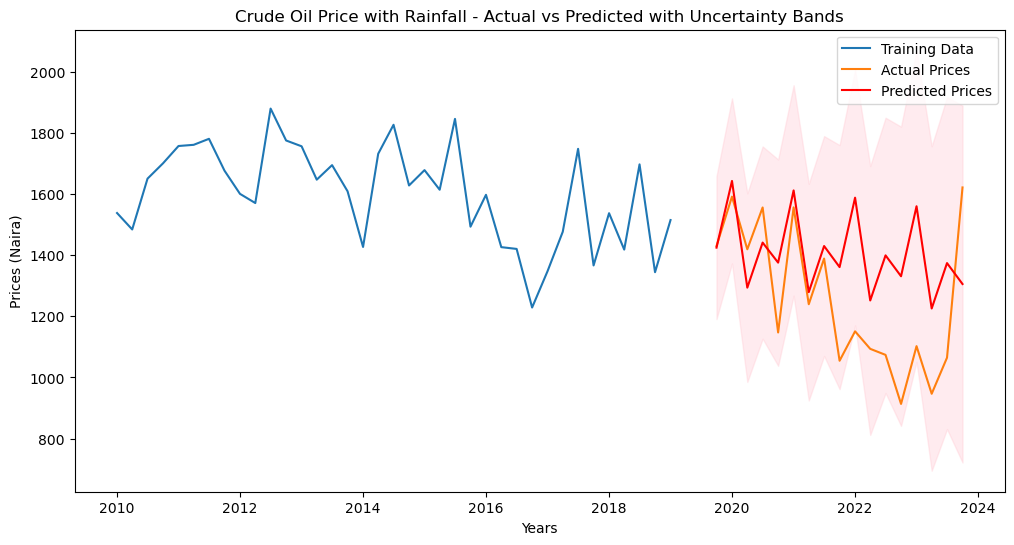

In [205]:
# Plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(train_aligned.index, train_aligned, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(test.index, Expred_mean, label='Predicted Prices', color='red')
# Plot confidence intervals
plt.fill_between(test.index, Expred_conf.iloc[:, 0], Expred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.xlabel('Years')
plt.ylabel('Prices (Naira)')
plt.title('Crude Oil Price with Rainfall - Actual vs Predicted with Uncertainty Bands')
plt.show()

In [206]:
Expred_mean

37    1424.467496
38    1642.542017
39    1293.649131
40    1440.989371
41    1375.441016
42    1611.560195
43    1278.952353
44    1429.697335
45    1360.844116
46    1587.819962
47    1251.767178
48    1399.193898
49    1330.901934
50    1559.793094
51    1225.535683
52    1373.939416
53    1305.531782
Name: predicted_mean, dtype: float64

      lb_stat  lb_pvalue
10  11.979289   0.286445


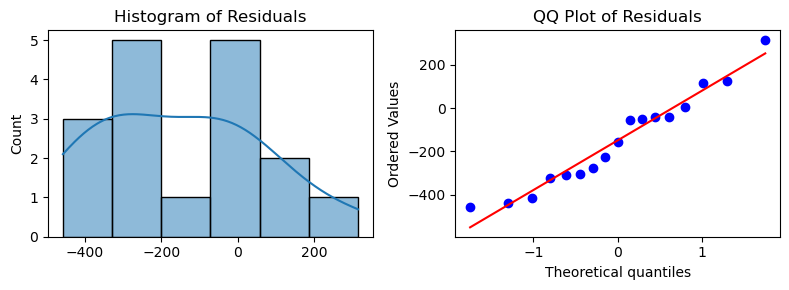

In [211]:

# Subtract pred_mean from test
residuals = test['CrudeOil'].values - Expred_mean

# Convert the result back to a pandas Series
residuals = pd.Series(residuals.values, index=test.index)
ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

print(ljung_box_test)

# Histogram and QQ plot for each residual
plt.figure(figsize=(8, 3))
    
plt.subplot(1, 2, 1)
sns.histplot(residuals.values, kde=True)
plt.title('Histogram of Residuals')
    
plt.subplot(1, 2, 2)
stats.probplot(residuals.values, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
    
plt.tight_layout()
plt.show()

In [321]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate errors
Exmae = mean_absolute_error(test['CrudeOil'].values, Expred_mean)
Exmape = np.mean(np.abs((test['CrudeOil'].values - Expred_mean) / test['CrudeOil'].values)) * 100
Exrmse = np.sqrt(mean_squared_error(test['CrudeOil'].values, Expred_mean))

# Print results
print(f'Mean Absolute Error (MAE): {Exmae}')
print(f'Mean Absolute Percentage Error (MAPE): {Exmape}')
print(f'Root Mean Squared Error (RMSE): {Exrmse}')


Mean Absolute Error (MAE): 215.63296576748164
Mean Absolute Percentage Error (MAPE): 19.192528211550442
Root Mean Squared Error (RMSE): 261.42206523640107


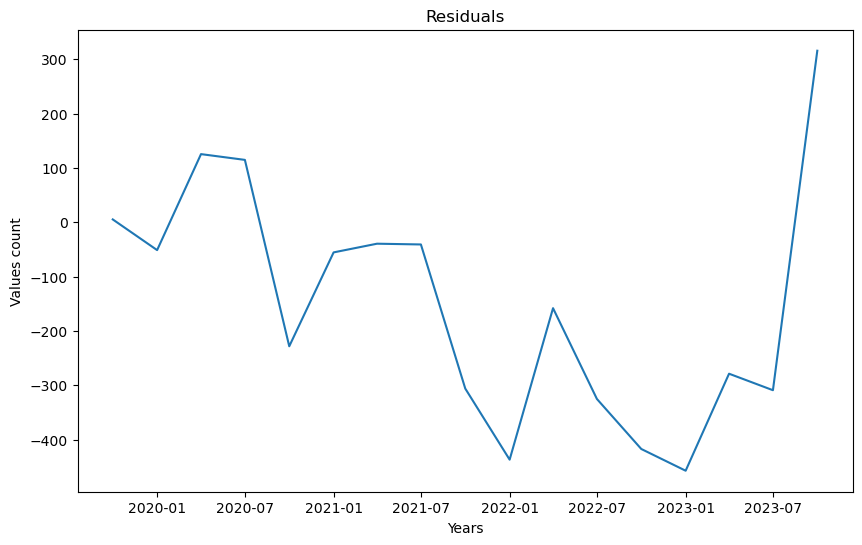

In [214]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Years')
plt.ylabel('Values count')
plt.show()

In [296]:
from statsmodels.tsa.seasonal import seasonal_decompose

forecast_steps = 20

# Decompose the RainData series
decomposition = seasonal_decompose(RainData['RainDta'], model='additive', period=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Heavy Rainfall: Amplify the trend
heavy_rain_trend = trend * 0.5  # Increasing the trend to simulate heavier rainfall

# Forecast future values using the amplified trend and seasonal components
trend_future = heavy_rain_trend[-12:].mean()  # Assuming the trend remains constant
seasonal_future = seasonal[:forecast_steps]  # Assuming the seasonal pattern repeats

exog_future_heavy = pd.Series(trend_future + seasonal_future.values)


In [297]:
forecastmodel = SARIMAX(train_aligned['CrudeOil'].values, 
                exog=exog_train_lag2_train, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,4))

forecastmodel_fit = forecastmodel.fit(disp=False)

# Make predictions
forecastpredictions = forecastmodel_fit.get_prediction(start=len(train_aligned['CrudeOil'].values), 
                                                       end=len(train_aligned['CrudeOil'].values) + len(test) - 1, 
                                                       exog=exog_test_Lag2, dynamic=False)
forecastpred_mean = forecastpredictions.predicted_mean
forecastpred_conf = forecastpredictions.conf_int()

In [298]:
# Forecast beyond the test data
forecast_steps = 20  # Number of steps to forecast into the future
forecast = forecastmodel_fit.get_forecast(steps=forecast_steps, exog=exog_future_heavy)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Combine historical data with forecasts
full_forecast = pd.concat([forecastpred_mean, forecast_mean])
full_conf = pd.concat([forecastpred_conf, forecast_conf])



In [294]:
# Decompose the RainData series
decomposition = seasonal_decompose(RainData['RainDta'], model='additive', period=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Heavy Rainfall: Amplify the trend
heavy_rain_trend = trend * 4.5  # Increasing the trend to simulate heavier rainfall

# Forecast future values using the amplified trend and seasonal components
trend_future2 = heavy_rain_trend[-12:].mean()  # Assuming the trend remains constant
seasonal_future2 = seasonal[:forecast_steps]  # Assuming the seasonal pattern repeats

exog_future_heavy2 = pd.Series(trend_future2 + seasonal_future2.values)

forecastmodel2 = SARIMAX(train_aligned['CrudeOil'].values, 
                exog=exog_train_lag2_train, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,4))

forecastmodel_fit2 = forecastmodel2.fit(disp=False)

# Make predictions
forecastpredictions2 = forecastmodel_fit2.get_prediction(start=len(train_aligned['CrudeOil'].values), 
                                                       end=len(train_aligned['CrudeOil'].values) + len(test) - 1, 
                                                       exog=exog_test_Lag2, dynamic=False)
forecastpred_mean2 = forecastpredictions2.predicted_mean
forecastpred_conf2 = forecastpredictions2.conf_int()

forecast2 = forecastmodel_fit2.get_forecast(steps=forecast_steps, exog=exog_future_heavy2)
forecast_mean2 = forecast2.predicted_mean
forecast_conf2 = forecast2.conf_int()



In [300]:
start_date = pd.to_datetime("2024-01-01")  # Set the start date for the forecast
forecast_dates = pd.date_range(start=start_date, periods=len(forecast_mean), freq='Q')
forecast_dates_pred = pd.date_range(start=start_date, periods=len(forecastpred_mean), freq='Q')
forecast_dates_conf = pd.date_range(start=start_date, periods=len(forecast_conf), freq='Q')

# Update forecast_mean to have these dates as the index
forecast_mean.index = forecast_dates
forecastpred_mean.index = forecast_dates_pred
forecast_conf.index = forecast_dates_conf

forecast_mean2.index = forecast_dates
forecastpred_mean2.index = forecast_dates_pred
forecast_conf2.index = forecast_dates_conf

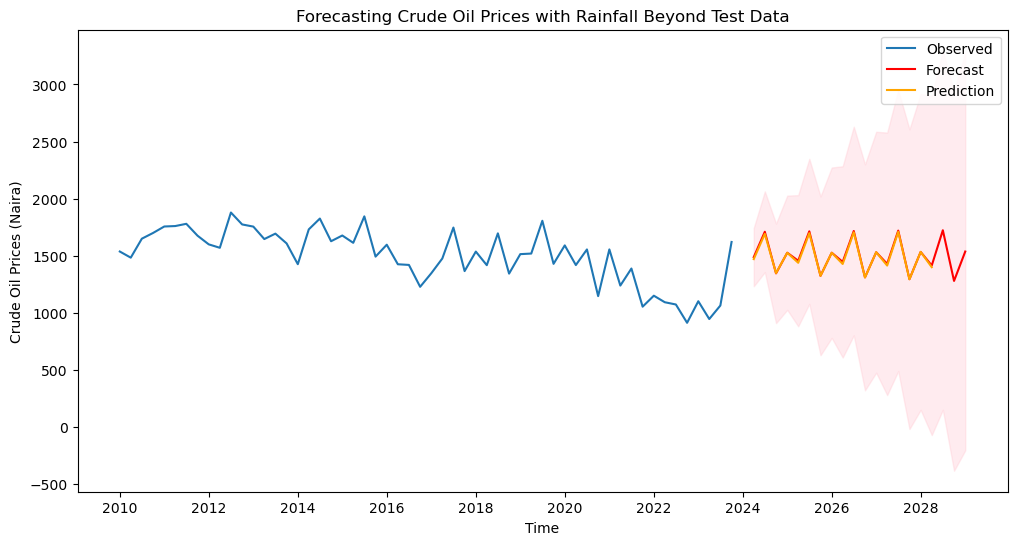

In [278]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(CrudeData.index, CrudeData['CrudeOil'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='red')
plt.plot(forecastpred_mean.index, forecastpred_mean.values, label='Prediction', color='orange')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (Naira)')
plt.title('Forecasting Crude Oil Prices with Rainfall Beyond Test Data')
plt.legend()
plt.show()

In [279]:
from sklearn.metrics import r2_score
import numpy as np

# Ensure the lengths are the same by slicing the observed data to match the forecast period
observed_values = full_forecast.iloc[-forecast_steps:]  # This assumes full_forecast contains the true observed values
predicted_values = forecast_mean

# Calculate RMSE
forrmse = np.sqrt(mean_squared_error(forecastpred_mean.values, forecast_mean[:-3].values))

# Calculate MAE
formae = mean_absolute_error(forecastpred_mean.values, forecast_mean[:-3].values)

# Calculate MAPE
formape = np.mean(np.abs((forecastpred_mean.values - forecast_mean[:-3].values) / forecastpred_mean.values)) * 100

# Calculate R² Score
forr2 = r2_score(forecastpred_mean.values, forecast_mean[:-3].values)

# Print the results
print(f'Root Mean Squared Error (RMSE): {forrmse}')
print(f'Mean Absolute Error (MAE): {formae}')
print(f'Mean Absolute Percentage Error (MAPE): {formape}')
print(f'R² Score: {forr2}')


Root Mean Squared Error (RMSE): 11.46010661029771
Mean Absolute Error (MAE): 8.550487612860827
Mean Absolute Percentage Error (MAPE): 0.5614295535538063
R² Score: 0.9931046139936657


In [303]:
forecast_mean

2024-03-31    1488.382084
2024-06-30    1710.691562
2024-09-30    1346.277438
2024-12-31    1527.039262
2025-03-31    1457.012869
2025-06-30    1714.398786
2025-09-30    1324.759264
2025-12-31    1527.219093
2026-03-31    1446.663850
2026-06-30    1717.425717
2026-09-30    1311.354468
2026-12-31    1531.339978
2027-03-31    1429.794351
2027-06-30    1720.662958
2027-09-30    1295.433352
2027-12-31    1534.237464
2028-03-31    1414.948481
2028-06-30    1723.834212
2028-09-30    1280.293630
2028-12-31    1537.513752
Freq: Q-DEC, Name: predicted_mean, dtype: float64

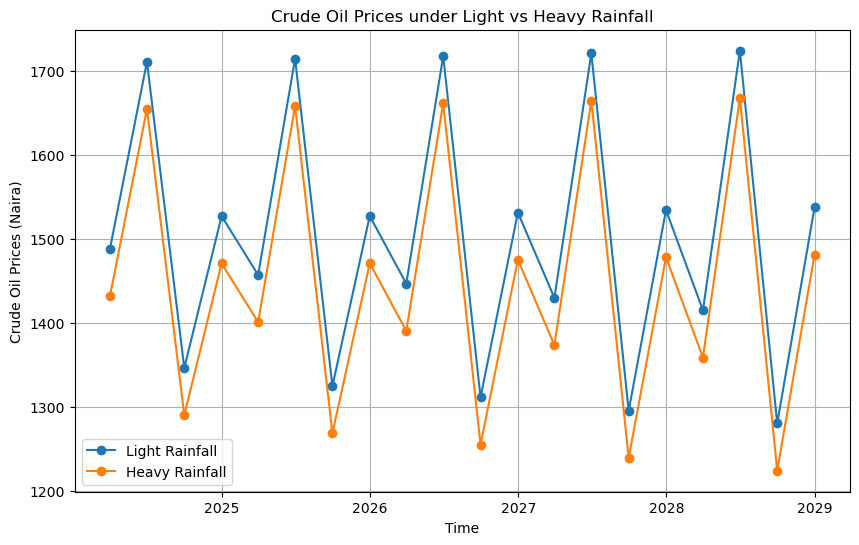

In [302]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot light rainfall results
plt.plot(forecast_mean.index, forecast_mean.values, label='Light Rainfall', marker='o')

# Plot heavy rainfall results
plt.plot(forecast_mean2.index, forecast_mean2.values, label='Heavy Rainfall', marker='o')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (Naira)')
plt.title('Crude Oil Prices under Light vs Heavy Rainfall')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [88]:
Dff_DropColumn.head(5)

,Year,Period,GDP,CrudeOil,RainDta,Year_Period,date,CrudeOil_First_Diff,CrudeOil_Second_Diff
0,2010,Q1,1537.63,1537.63,46.50,2010-Q1,2010-01-01,NaN,NaN
1,2010,Q2,1483.89,1483.89,162.77,2010-Q2,2010-04-01,-53.74,NaN
2,2010,Q3,1650.03,1650.03,198.63,2010-Q3,2010-07-01,166.14,219.88
3,2010,Q4,1700.12,1700.12,25.17,2010-Q4,2010-10-01,50.09,-116.05
4,2011,Q1,1756.68,1756.68,23.13,2011-Q1,2011-01-01,56.56,6.47


In [305]:
from prophet import Prophet
import pandas as pd

# daf should have columns: 'ds' (date), 'y' (crude oil prices), 'rainfall' (rainfall data)
daf = Dff_DropColumn.drop(columns=['Year','Period','GDP','Year_Period','CrudeOil_First_Diff','CrudeOil_Second_Diff'])
Maindf = daf.drop(columns=['RainDta'])
# Rename the columns: CrudeOil to 'y' and date to 'ds'
Maindf.rename(columns={'CrudeOil': 'y', 'date': 'ds'}, inplace=True)
Maindf['Rainfall'] = daf['RainDta']

In [306]:
Maindf.head(3)

,y,ds,Rainfall
0,1537.63,2010-01-01,46.50
1,1483.89,2010-04-01,162.77
2,1650.03,2010-07-01,198.63


In [307]:
# Define the Prophet model
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)  # Adding quarterly seasonality
model.add_regressor('Rainfall')

# Fit the model
model.fit(Maindf)

# Future dataframe for forecasting
future = model.make_future_dataframe(periods=8, freq='Q')  # Forecasting 2 years ahead (8 quarters)


12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing


In [315]:
rainLen = len(future) - len(Maindf)
exog_future = exog_future_heavy.head(rainLen)
exog_future2 = exog_future_heavy2.head(rainLen)
exog_future

0    -24.974312
1     96.275207
2    130.565976
3     31.672130
4    -24.974312
5     96.275207
6    130.565976
7     31.672130
dtype: float64

In [316]:
# Ensure the future DataFrame includes 'RainDta' for the future periods
future['Rainfall'] = np.concatenate([Maindf['Rainfall'].values, exog_future])

# Make predictions
forecast = model.predict(future)

In [317]:
# Ensure the future DataFrame includes 'RainDta' for the future periods
future['Rainfall'] = np.concatenate([Maindf['Rainfall'].values, exog_future2])

# Make predictions
forecast2 = model.predict(future)

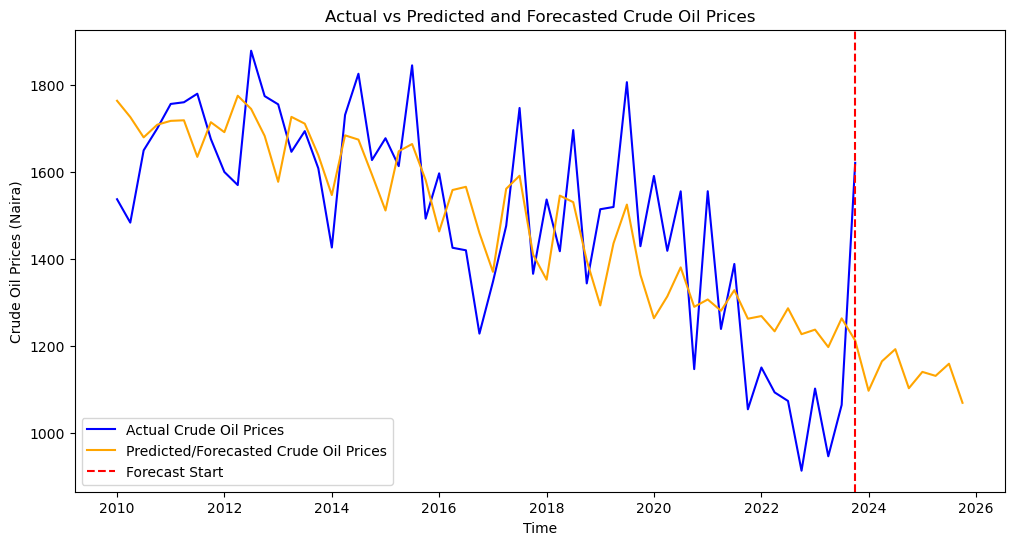

In [312]:
# Plot the actual, predicted, and forecasted values
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Maindf['ds'], Maindf['y'], label='Actual Crude Oil Prices', color='blue')

# Plot predictions (including forecast)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted/Forecasted Crude Oil Prices', color='orange')

# Highlight forecasted area
plt.axvline(x=Maindf['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (Naira)')
plt.title('Actual vs Predicted and Forecasted Crude Oil Prices')
plt.legend()

# Show the plot
plt.show()

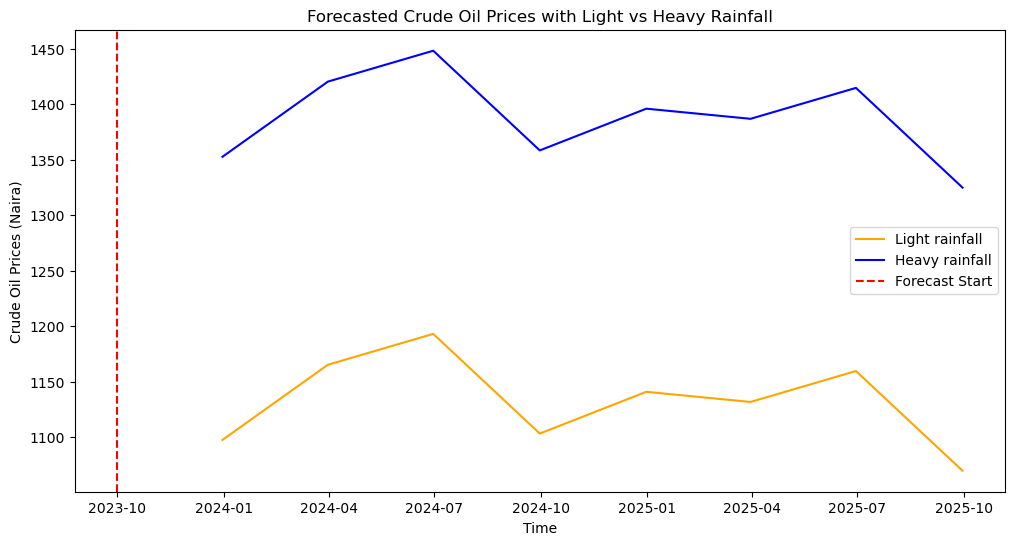

In [320]:
# Determine the point where the forecast starts
forecast_start_date = Maindf['ds'].max()

# Filter the forecast DataFrame to include only dates after the forecast start date
light_rainfall_forecast_only = forecast[forecast['ds'] > forecast_start_date]
heavy_rainfall_forecast_only = forecast2[forecast2['ds'] > forecast_start_date]

# Plot the actual, predicted, and forecasted values
plt.figure(figsize=(12, 6))

# Plot the filtered forecast data (only the forecast starting from the red line)
plt.plot(light_rainfall_forecast_only['ds'], light_rainfall_forecast_only['yhat'], label='Light rainfall', color='orange')
plt.plot(heavy_rainfall_forecast_only['ds'], heavy_rainfall_forecast_only['yhat'], label='Heavy rainfall', color='blue')

# Highlight forecasted area start
plt.axvline(x=forecast_start_date, color='red', linestyle='--', label='Forecast Start')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (Naira)')
plt.title('Forecasted Crude Oil Prices with Light vs Heavy Rainfall')
plt.legend()

# Show the plot
plt.show()

In [322]:
# Merge the actual and predicted values for the historical period
actual_vs_predicted = pd.merge(Maindf, forecast[['ds', 'yhat']], on='ds')

# Calculate MAE
mae = mean_absolute_error(actual_vs_predicted['y'], actual_vs_predicted['yhat'])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE and RMSE
mse = mean_squared_error(actual_vs_predicted['y'], actual_vs_predicted['yhat'])
rmse = np.sqrt(mse)
#print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((actual_vs_predicted['y'] - actual_vs_predicted['yhat']) / actual_vs_predicted['y'])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate the square root of the sum of squared residuals
sum_squared_residuals = np.sum((actual_vs_predicted['y'] - actual_vs_predicted['yhat']) ** 2)
root_square_sum_squared_residuals = np.sqrt(sum_squared_residuals)
#print(f"Root Square of Sum of Squared Residuals: {root_square_sum_squared_residuals}")

Mean Absolute Error (MAE): 136.50858549011977
Root Mean Squared Error (RMSE): 162.15905877784948
Mean Absolute Percentage Error (MAPE): 9.698867508084161%


In [117]:
datess = pd.date_range(start='2010-01-01', periods=12, freq='Q')  # 3 years of quarterly data
crude_ooil = np.random.normal(1500, 100, len(datess))  # Simulated crude oil prices
rainfalll = np.random.uniform(20, 200, len(datess))  # Simulated rainfall data

# Create the DataFrame
daaf = pd.DataFrame({
    'ds': datess,
    'y': crude_ooil,
    'RainDta': rainfalll
})

daaf

,ds,y,RainDta
0,2010-03-31,1409.469608,166.125178
1,2010-06-30,1489.494793,21.906104
2,2010-09-30,1556.934000,72.674380
3,2010-12-31,1402.932642,129.065071
4,2011-03-31,1480.415769,64.671516
5,2011-06-30,1410.958319,138.612014
6,2011-09-30,1485.016698,159.711397
7,2011-12-31,1552.056653,31.947305
8,2012-03-31,1510.883147,198.244501
9,2012-06-30,1519.397022,141.985841


In [118]:
exog_future = np.random.uniform(20, 200, len(future) - len(daaf))

exog_future

array([ 44.43447755, 148.2420573 , 108.49565825,  61.39599142,
       100.77907677,  75.7659738 , 130.67706722, 153.78444465,
        71.55555148,  38.46210107, 140.70085701, 188.70294489,
       108.24915564, 109.86401467, 143.24849487, 142.62911131,
        71.82622881, 112.97695536, 168.8522156 , 128.56589222,
        49.96940642, 188.29178312,  94.61204276, 113.86198229,
       108.37550425, 152.40945812, 181.51160984, 106.61090384,
        59.388977  , 198.9729356 ,  70.09597274, 119.87912852,
       156.65994224,  37.08910121, 118.69231605,  73.31750489,
        25.62741404,  91.65150317, 131.49426865, 141.77262203,
       123.37329959, 169.69428754,  20.52740243, 120.79328352,
       170.55906776, 141.57678031, 103.07335918, 143.82567036,
       177.92146077, 176.78410641,  84.51849264,  51.02090749])

In [ ]:
# Define the Prophet model
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)  # Adding quarterly seasonality
model.add_regressor('RainDta')  # Adding RainDta as a regressor

# Fit the model to the historical data
model.fit(daaf)

# Create the future dataframe for forecasting (8 quarters ahead)
future = model.make_future_dataframe(periods=8, freq='Q')  # Forecasting 2 years ahead (8 quarters)

# Generate some forecasted rainfall data for the future periods (to replace 'exog_future_heavy')
# Here we'll just generate random values for simplicity


# Ensure the future DataFrame includes 'RainDta' for the future periods
future['RainDta'] = np.concatenate([daf['RainDta'].values, exog_future_heavy])

# Make predictions
forecast = model.predict(future)

# View the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())